In [14]:
from dask.distributed import Client

# remote Distributed Mode
# client = Client('tcp://192.168.2.100:8786')

# Local Multi-thread
# client = Client(processes=False, threads_per_worker=2,
#                 n_workers=2, memory_limit='2GB')

# Local Multi-Process
# client = Client(processes=True, threads_per_worker=2,
#                 n_workers=2, memory_limit='2GB')

# Local Single-Thread
from dpyacl.core.collections import IndexCollection
from dpyacl.core.misc import split
client = None


In [15]:
from sklearn.datasets import load_breast_cancer

X,y=load_breast_cancer(return_X_y=True) #import the dataset

# partition the data
train_idx, test_idx, label_idx, unlabel_idx = split(
    X=X,
    y=y,
    test_ratio=0.3,
    initial_label_rate=0.05,
    split_count=1,
    all_class=True)

# convert to indexed collection
train_idx = IndexCollection(train_idx[0])
test_idx = IndexCollection(test_idx[0])
label_idx = IndexCollection(label_idx[0])
unlabel_idx = IndexCollection(unlabel_idx[0])


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation

from dpyacl.core.stop_criteria import MaxIteration
from dpyacl.strategies.single_label import QueryEntropySampling
from dpyacl.metrics.evaluation import Accuracy, F1, HammingLoss
from dpyacl.oracle import SimulatedOracle

# Create the learning technique
batch_size = 5
epochs = 20

ml_technique = Sequential()
ml_technique.add(Dense(input_dim=30, units=30))
ml_technique.add(Dense(input_dim=30, units=30))
ml_technique.add(Dense(input_dim=30, units=2))
ml_technique.add(Activation('softmax'))
ml_technique.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the active learning components
stopping_criteria = MaxIteration(25)
query_strategy = QueryEntropySampling()
performance_metrics = [Accuracy(), F1(average='weighted'), HammingLoss()]
oracle = SimulatedOracle(labels=y)

In [17]:
%%time
import time

from dpyacl.core.state import StateItem, State

start_time = time.time()
experimentState = State(round=0,
                        train_idx=train_idx, test_idx=test_idx,
                        init_L=label_idx, init_U=unlabel_idx,
                        performance_metrics=[metric.metric_name for metric in performance_metrics],
                        verbose=True)

while not stopping_criteria.is_stop() and len(unlabel_idx) > 0:

    label_x = X[label_idx.index, :]
    label_y = y[label_idx.index]
    test_x = X[test_idx, :]
    test_y = y[test_idx]

    # Train and evaluate Model over the labeled instances
    ml_technique.fit(label_x, label_y, batch_size=batch_size, epochs=epochs, verbose=True)

    # predict the results over the labeled test instances
    label_pred = ml_technique.predict_classes(test_x)

    # performance calc for all metrics
    label_perf = []
    for metric in performance_metrics:
        value = metric.compute(y_true=test_y, y_pred=label_pred)
        label_perf.append({"name": metric.metric_name, "value": value})

    # use the query strategy for selecting the indexes
    select_ind = query_strategy.select(X=X,
                                       y=y,
                                       label_index=label_idx,
                                       unlabel_index=unlabel_idx,
                                       batch_size=batch_size,
                                       model=ml_technique,
                                       client=client
                                       )

    # show label values
    oracle.query(instances=X[select_ind], indexes=select_ind)

    # update label and unlabel instaces
    label_idx.update(select_ind)
    unlabel_idx.difference_update(select_ind)

    # save intermediate results
    experimentState.add_state(
        StateItem(select_index=select_ind,
                  performance_metrics=[metric['name'] for metric in label_perf],
                  performance=label_perf))

    # update stopping_criteria
    stopping_criteria.update_information(experimentState)

end_time = time.time() - start_time
print(end_time)


Epoch 1/20
4/4 [==============================] - 0s 790us/step - loss: 74.1278 - accuracy: 0.4000
Epoch 2/20
4/4 [==============================] - 0s 688us/step - loss: 18.0753 - accuracy: 0.4500
Epoch 3/20
4/4 [==============================] - 0s 552us/step - loss: 6.8038 - accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 0s 998us/step - loss: 4.3277 - accuracy: 0.5500
Epoch 5/20
4/4 [==============================] - 0s 762us/step - loss: 2.7747 - accuracy: 0.6500
Epoch 6/20
4/4 [==============================] - 0s 664us/step - loss: 1.9391 - accuracy: 0.6000

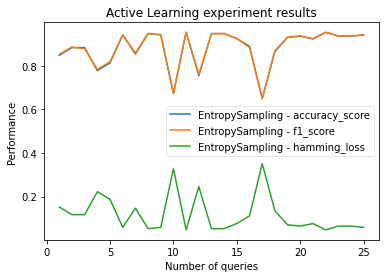

In [18]:
from dpyacl.experiment import ExperimentAnalyserFactory

query_analyser = ExperimentAnalyserFactory.experiment_analyser(
    performance_metrics=[metric.metric_name for metric in performance_metrics],
    method_name=query_strategy.query_function_name,
    method_results=[experimentState],
    type="queries"
)
# get a brief description of the experiment
query_analyser.plot_learning_curves(title='Active Learning experiment results')